### PNN 模型


In [27]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import re

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding, Concatenate, Dropout, Input, Layer
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

import os

In [28]:

def sparseFeature(feat, feat_num, embed_dim=4):
    """
    create dictionary for sparse feature
    :param feat: feature name
    :param feat_num: the total number of sparse features that do not repeat
    :param embed_dim: embedding dimension
    :return:
    """
    return {'feat': feat, 'feat_num': feat_num, 'embed_dim': embed_dim}

def denseFeature(feat):
    """
    create dictionary for dense feature
    :param feat: dense feature name
    :return:
    """
    return {'feat': feat}


def create_criteo_dataset(file_train, file_test, embed_dim=8, read_part=False, sample_num=100000, test_size=0.2):

    # 训练数据
    df_train = pd.read_csv(file_train)
    # 测试数据
    df_apply_new = pd.read_csv(file_test)
    # 合并训练集，验证集
    data_df = pd.concat([df_train, df_apply_new], axis=0, ignore_index=True)
    data_df['label'] = data_df['label'].fillna(str(-1))


    # 稀疏特征 label 类型的特征 不需要归一化，非连续
    sparse_features = ['gender', 'province', 'city', 'make', 'model']
    # 稠密特征 需要归一化 连续性的特征
    dense_features = ['age']


    def clean_data(string):
        # 对数据清洗
        string = re.sub(r"[^0-9()]", "", string)
        return string.strip().lower()


    # ==============Age ===================
    # 处理Age
    # 缺失值填充
    data_df['age'] = data_df['age'].fillna(-1)
    a = data_df['age'].copy()
    a = a.apply(lambda x: str(x).lower())
    # 统一字符类型转化成str()
    a = a.apply(lambda x: clean_data(x))
    data_df['age'] = a
    data_df['age'] = data_df['age'].astype('int')  # 转换数据类型为 int 类型


    # ==============appid_num ===================
    appid_num = data_df['appid']
    def get_appid_num(string):
        # 对数据清洗
        string = string.split(',')
        return len(string)

    appid_num = appid_num.apply(lambda x: get_appid_num(x))
    data_df['appid_num'] = appid_num
    dense_features = dense_features + ['appid_num']


    data_df[sparse_features] = data_df[sparse_features].fillna('-1')
    data_df[dense_features] = data_df[dense_features].fillna(0)

    # ==============gender ===================
    data_df['gender'] = data_df['gender'].astype('str')  # 转换数据类型为 int 类型


    for feat in sparse_features:
        le = LabelEncoder()
        data_df[feat] = le.fit_transform(data_df[feat])


    # ====================================================
    mms = MinMaxScaler(feature_range=(0, 1))
    data_df[dense_features] = mms.fit_transform(data_df[dense_features])


    # 统计dense_features、sparse_features每个特征的个数和
    feature_columns = [[denseFeature(feat) for feat in dense_features]] + \
                      [[sparseFeature(feat, len(data_df[feat].unique()), embed_dim=embed_dim)
                        for feat in sparse_features]]

    # 划分训练集和测试集
    """
    ### 本次案例中：将所有的样本作为训练集。
    ### 使用全部的样本作为训练集，通过交叉验证的方法划分为：测试集+验证集
    """
    data_df_1 = data_df[data_df.label != '-1']  # data.click != -1的样本为训练的样本集合
    train, test = train_test_split(data_df_1, test_size=test_size)

    train_X = [train[dense_features].values.astype('int32'), train[sparse_features].values.astype('int32')]
    train_y = train['label'].values.astype('int32')
    test_X = [test[dense_features].values.astype('int32'), test[sparse_features].values.astype('int32')]
    test_y = test['label'].values.astype('int32')


    # 划分需要预测的样本集
    data_df_2 = data_df[data_df.label == '-1']  # data.click == -1的样本为需要预测的样本集合
    total_test = [data_df_2[dense_features].values.astype('int32'), data_df_2[sparse_features].values.astype('int32')]

    return feature_columns, (train_X, train_y), (test_X, test_y), total_test

In [29]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# you can modify your file path
file_train = '../data/train.csv'
file_test = '../data/apply_new.csv'


embed_dim = 8
read_part = True
sample_num = 6000000
test_size = 0.2

# ========================== Create dataset =======================
feature_columns, train, test, vail = create_criteo_dataset(file_train=file_train,
                                                           file_test=file_test,
                                                           embed_dim=embed_dim,
                                                           read_part=read_part,
                                                           sample_num=sample_num,
                                                           test_size=test_size)

F:\Python\1\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [30]:
feature_columns

[[{'feat': 'age'}, {'feat': 'appid_num'}],
 [{'feat': 'gender', 'feat_num': 3, 'embed_dim': 8},
  {'feat': 'province', 'feat_num': 34, 'embed_dim': 8},
  {'feat': 'city', 'feat_num': 316, 'embed_dim': 8},
  {'feat': 'make', 'feat_num': 1549, 'embed_dim': 8},
  {'feat': 'model', 'feat_num': 129, 'embed_dim': 8}]]

In [34]:

class DNN(Layer):
    """
	Deep Neural Network
	"""

    def __init__(self, hidden_units, activation='relu', dropout=0.):
        """
		:param hidden_units: A list. Neural network hidden units.
		:param activation: A string. Activation function of dnn.
		:param dropout: A scalar. Dropout number.
		"""
        super(DNN, self).__init__()
        self.dnn_network = [Dense(units=unit, activation=activation) for unit in hidden_units]
        self.dropout = Dropout(dropout)

    def call(self, inputs, **kwargs):
        x = inputs
        for dnn in self.dnn_network:
            x = dnn(x)
        x = self.dropout(x)
        return x


class PNN(keras.Model):
    def __init__(self, feature_columns, hidden_units, mode='in', dnn_dropout=0.,
                 activation='relu', embed_reg=1e-4, w_z_reg=1e-4, w_p_reg=1e-4, l_b_reg=1e-4):
        """
        Product-based Neural Networks
        :param feature_columns: A list. dense_feature_columns + sparse_feature_columns
        :param hidden_units: A list. Neural network hidden units.
        :param mode: A string. 'in' IPNN or 'out'OPNN.
        :param activation: A string. Activation function of dnn.
        :param dnn_dropout: A scalar. Dropout of dnn.
        :param embed_reg: A scalar. The regularizer of embedding.
        :param w_z_reg: A scalar. The regularizer of w_z_ in product layer
        :param w_p_reg: A scalar. The regularizer of w_p in product layer
        :param l_b_reg: A scalar. The regularizer of l_b in product layer
        """
        super(PNN, self).__init__()
        # inner product or outer product
        self.mode = mode
        self.dense_feature_columns, self.sparse_feature_columns = feature_columns
        # the number of feature fields
        self.field_num = len(self.sparse_feature_columns)
        self.embed_dim = self.sparse_feature_columns[0]['embed_dim']
        # The embedding dimension of each feature field must be the same
        self.embed_layers = {
            'embed_' + str(i): Embedding(input_dim=feat['feat_num'],
                                         input_length=1,
                                         output_dim=feat['embed_dim'],
                                         embeddings_initializer='random_uniform',
                                         embeddings_regularizer=l2(embed_reg))
            for i, feat in enumerate(self.sparse_feature_columns)
        }
        # parameters
        self.w_z = self.add_weight(name='w_z',
                                   shape=(self.field_num, self.embed_dim, hidden_units[0]),
                                   initializer='random_uniform',
                                   regularizer=l2(w_z_reg),
                                   trainable=True
                                   )
        if mode == 'in':
            self.w_p = self.add_weight(name='w_p',
                                       shape=(self.field_num, self.field_num, hidden_units[0]),
                                       initializer='random_uniform',
                                       reguarizer=l2(w_p_reg),
                                       trainable=True)
        # out
        else:
            self.w_p = self.add_weight(name='w_p',
                                       shape=(self.embed_dim, self.embed_dim, hidden_units[0]),
                                       initializer='random_uniform',
                                       regularizer=l2(w_p_reg),
                                       trainable=True)
        self.l_b = self.add_weight(name='l_b', shape=(hidden_units[0], ),
                                   initializer='random_uniform',
                                   regularizer=l2(l_b_reg),
                                   trainable=True)
        # dnn
        self.dnn_network = DNN(hidden_units[1:], activation, dnn_dropout)
        self.dense_final = Dense(1)

    def call(self, inputs):
        dense_inputs, sparse_inputs = inputs
        dense_inputs = tf.cast(dense_inputs, dtype=tf.float32)  # dense_inputs 类型转化成float
        embed = [self.embed_layers['embed_{}'.format(i)](sparse_inputs[:, i])
                 for i in range(sparse_inputs.shape[1])]
        embed = tf.transpose(tf.convert_to_tensor(embed), [1, 0, 2])  # (None, field_num, embed_dim)
        z = embed  # (None, field, embed_dim)
        # product layer
        if self.mode == 'in':
            p = tf.matmul(embed, tf.transpose(embed, [0, 2, 1]))  # (None, field_num, field_num)
        else:  # out
            f_sum = tf.reduce_sum(embed, axis=1, keepdims=True)  # (None, 1 embed_num)
            p = tf.matmul(tf.transpose(f_sum, [0, 2, 1]), f_sum)  # (None, embed_num, embed_num)

        l_z = tf.tensordot(z, self.w_z, axes=2)  # (None, h_unit)
        l_p = tf.tensordot(p, self.w_p, axes=2)  # (None, h_unit)
        l_1 = tf.nn.relu(tf.concat([l_z + l_p + self.l_b, dense_inputs], axis=-1))
        # dnn layer
        dnn_x = self.dnn_network(l_1)
        outputs = tf.nn.sigmoid(self.dense_final(dnn_x))
        return outputs

    def summary(self):
        dense_inputs = Input(shape=(len(self.dense_feature_columns),), dtype=tf.float32)
        sparse_inputs = Input(shape=(len(self.sparse_feature_columns),), dtype=tf.int32)
        keras.Model(inputs=[dense_inputs, sparse_inputs],
                    outputs=self.call([dense_inputs, sparse_inputs])).summary()


In [35]:
read_part = True
sample_num = 6000000
test_size = 0.2

embed_dim = 8
mode = 'in'
dnn_dropout = 0.5
hidden_units = [256, 128, 64]

learning_rate = 0.001
batch_size = 256
epochs = 30

# ========================== Create dataset =======================
train_X, train_y = train
test_X, test_y = test

# ============================Build Model==========================
model = PNN(feature_columns, hidden_units, dnn_dropout)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_15 (T [(None,)]            0           input_8[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_16 (T [(None,)]            0           input_8[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_17 (T [(None,)]            0           input_8[0][0]                    
____________________________________________________________________________________________

In [36]:
# ============================Compile============================
model.compile(loss=binary_crossentropy, 
              optimizer=Adam(learning_rate=learning_rate),
              metrics=[AUC()])
# ==============================Fit==============================
history = model.fit(
    train_X,
    train_y,
    epochs=epochs,
    callbacks=[EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)],  # checkpoint
    batch_size=batch_size,
    validation_split=0.1
)
# ===========================Test==============================
print('test AUC: %f' % model.evaluate(test_X, test_y)[1])

Train on 216000 samples, validate on 24000 samples
Epoch 1/30


F:\Python\1\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
F:\Python\1\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


216000/216000 [==============================] - 5s 23us/sample - loss: 0.6169 - auc_3: 0.7015 - val_loss: 0.6052 - val_auc_3: 0.7213
Epoch 2/30
216000/216000 [==============================] - 4s 17us/sample - loss: 0.6064 - auc_3: 0.7167 - val_loss: 0.6044 - val_auc_3: 0.7229
Epoch 3/30
216000/216000 [==============================] - 4s 17us/sample - loss: 0.6058 - auc_3: 0.7179 - val_loss: 0.6034 - val_auc_3: 0.7232
Epoch 4/30
216000/216000 [==============================] - 4s 17us/sample - loss: 0.6055 - auc_3: 0.7187 - val_loss: 0.6034 - val_auc_3: 0.7229
60000/1 [======================================================================================================================================================================================================================================================================================================================================================================================================================================

test AUC: 0.715856


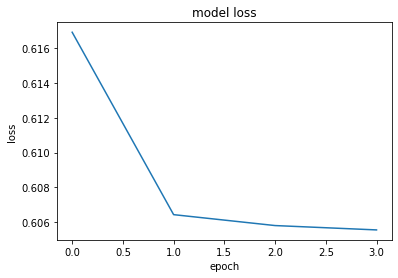

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

参考博客：model.predict 二分类 <br>
https://zhuanlan.zhihu.com/p/79390766 <br>
https://blog.csdn.net/xiaocxyczh/article/details/85226639 <br>
y_pred = model.predict_classes(X_test, batch_size = 20, verbose = 1)


In [38]:
pre_data = model.predict(vail)
pre_data

array([[0.4248253 ],
       [0.40574747],
       [0.3734513 ],
       ...,
       [0.5817351 ],
       [0.00895604],
       [0.00460273]], dtype=float32)

In [39]:
# 读入文件并写入预测值
label_submission = pd.read_csv('../data/submit_sample.csv')
label_submission.head()

,user_id,category_id
0,1400001,0
1,1400002,1
2,1400003,0
3,1400004,0
4,1400005,0


In [40]:
threshold = 0.5
result = []
for pred in pre_data:
    result.append(1 if pred > threshold else 0)

In [41]:
result

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,


In [42]:
label_submission['category_id'] = result

In [43]:
label_submission

,user_id,category_id
0,1400001,0
1,1400002,0
2,1400003,0
3,1400004,0
4,1400005,1
...,...,...
99995,1499996,0
99996,1499997,0
99997,1499998,1
99998,1499999,0


In [44]:
label_submission.to_csv("../submission/submission_PNN.csv",index=False)